# Inference: Logistic Growth with Combined Gaussian Error

This example shows you how to perform Bayesian inference on a time-series problem with a combined Gaussian error, using [Hamiltonian Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).

A combined Gaussian error is a Gaussian error whose standard deviation receives a constant contribution $\sigma _{\text{base}}$, and a contribution $\sigma _{\text{rel}}$ that scales with the model output. In other words, for a model $f(t; \theta)$ its combined Gaussian error is

\begin{equation*}
    \varepsilon = \left(\sigma _{\text{base}} + \sigma _{\text{rel}} f(t; \theta)^{\eta}\right) \varepsilon _n,
\end{equation*}

where $\eta $ is some constant that controls the relative scaling behaviour of the error. $\varepsilon _n$ is a standard Gaussian random variable, $\varepsilon _n\sim \mathcal{N}(0, 1)$.

As a toy time-series we consider a logistic Growth

\begin{equation*}
    f(t; \theta) = \frac{k}{1 + (k / f_0 - 1) e^{-r t}},
\end{equation*}

where the model parameters $\theta = (f_0, r, k)$ is the initial population size $f(t=0, \theta) = f_0$, the growth rate $r$ and the carrying capacity $k$. A logistic growth model with a combined Gaussian error

\begin{equation*}
    y(t; \theta, \sigma _{\text{base}}, \eta, \sigma _{\text{rel}}) = f(t; \theta)f(t, \theta) + \left(\sigma _{\text{base}} + \sigma _{\text{rel}} f(t; \theta)^{\eta}\right) \varepsilon _n,
\end{equation*}

has thus 6 model parameters which we may want to learn from data.

## Generating data

To illustrate how Bayesian inference may be used to learn the parameters of a logistic growth model with a combined Gaussian error, let us generate some data for a fixed set of model parameters

\begin{equation*}
    (f_0, r, k, \sigma _{\text{base}}, \eta, \sigma _{\text{rel}}) = (2, 0.015, 500, 10, 1.1, 0.05).
\end{equation*}

In [22]:
#
# Generate data for a logistic growth with a combined Gaussian error.
#

import numpy as np
import pints.toy


# Define model parameters
parameters = [2, 0.015, 500, 10, 1.1, 0.05]
f_0, r, k, sigma_base, eta, sigma_rel = true_parameters

# Instantiate logistic growth model with f(t=0) = f_0
model = pints.toy.LogisticModel(initial_population_size=f_0)

# Define measurement time points
times = np.linspace(start=0, stop=1000, num=200)

# Solve logistic growth model
model_output = model.simulate(parameters=[r, k], times=times)

# Add noise to the model output according to the combined Gaussian error model
# Draw a standard Gaussian random variable for each model output
gauss = np.random.normal(loc=0.0, scale=1.0, size=len(model_output))

# Scale standard Gaussian noise according to error model
error = (sigma_base + sigma_rel * model_output**eta) * gauss

# Add noise to model output
observations = model_output + error

# Save data as time-observation tuples
data = np.vstack([times, observations])

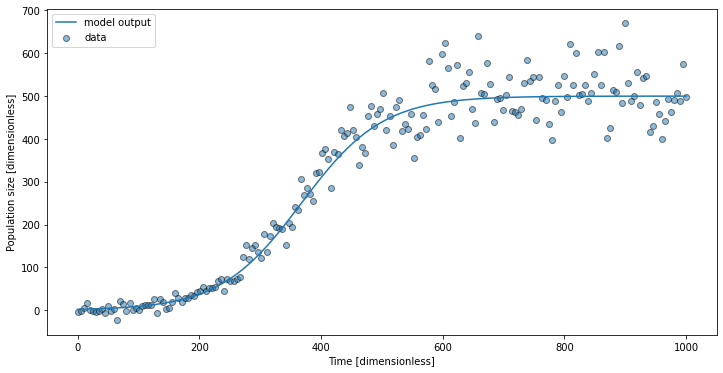

In [23]:
#
# Illustrate data.
#
# This cell needs the above defined data and model output:
# [data, model_output]
#

import matplotlib.pyplot as plt


# Create figure
plt.figure(figsize=(12, 6))

# Plot model output (no noise)
plt.plot(data[0, :], model_output, label='model output')

# Plot generated data
plt.scatter(data[0, :], data[1, :], label='data', edgecolors='black', alpha=0.5)

# Create X and Y axis title
plt.xlabel('Time [dimensionless]')
plt.ylabel('Population size [dimensionless]')

# Create legend
plt.legend()

# Show figure
plt.show()

## Inference of model parameters

We now try to recover the model parameters using 

1. [`pints.HaarioACMC`](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_ac_mcmc.html)
2. [`pints.HamiltonianMCMC`](https://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).

In order to do that we need to construct a [`pints.LogPosterior`](https://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPosterior) that incorporates the above simulated data, the logistic growth model and the error model. For a detailed introduction how to do this in [pints](https://pints.readthedocs.io/en/latest/), please have a look at the dedicated [notebooks](https://github.com/pints-team/pints/blob/master/examples/sampling/first-example.ipynb).

Let us simplify the inference by fixing the initial population size $f_0$ and the carrying capacity $k$ to the true values.

In [26]:
#
# Construct posterior.
#
# Step 1: Wrap logistic growth model in a pints.ForwardModel()
# Step 2: Create a pints.SingleOutputProblem(), combining the data and the wrapped logostic growth model.
# Step 3: Create a pints.CombinedGaussianLogLikelihood() from the pints.SingleOutputProblem()
# Step 4: Define pints.LogPrior() for the model parameters.
# Step 5: Combine priors and likelihood to create a pints.LogPosterior().
#
# This cell needs the above defined true parameters, and the generated data:
# [parameters, data]
#

import numpy as np
import pints
import pints.toy


# Get true initial population size and carrying capacity
f_0 = parameters[0]
k = parameters[2]

# Forget about f_0 and k (we won't infer those parameters)
true_parameters = np.hstack([parameters[1:2], parameters[3:]])

# Create a wrapper around the logistic model
class Model(pints.ForwardModel):
    def __init__(self, f_0, k):
        self._k = k
        self._model = pints.toy.LogisticModel(initial_population_size=f_0)
    def simulate(self, parameters, times):
        return self._model.simulate(parameters=[parameters[0], self._k], times=times)
    def simulateS1(self, x, times):
        # Compute model output and gradients w.r.t. r and k
        values, gradient = self._model.simulateS1(parameters=[parameters[0], self._k], times=times)

        # Get gradient w.r.t. r
        gradient = gradient[:, 0]

        return values, gradient
    def n_parameters(self):
        return 1

# Create an inverse problem which links the logistic growth model to the data
problem = pints.SingleOutputProblem(model=Model(f_0=f_0, k=k), times=data[0, :], values=data[1, :])

# Create the combined Gaussian error log-likelihood
log_likelihood = pints.CombinedGaussianLogLikelihood(problem)

# Create uniform priors for [r, sigma_base, eta, sigma_rel]
log_prior_r = pints.UniformLogPrior(
    [0.01],
    [0.05]
)
log_prior_sigma_base = pints.UniformLogPrior(
    [1],
    [20]
)
log_prior_eta = pints.UniformLogPrior(
    [0.5],
    [1.5]
)
log_prior_sigma_rel = pints.UniformLogPrior(
    [0.01],
    [0.2]
)
log_prior = pints.ComposedLogPrior(
    log_prior_r, log_prior_sigma_base, log_prior_eta, log_prior_sigma_rel)

# Create posterior
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

### 1. Infer parameters with Haario Adaptive Covariance MCMC

In [40]:
#
# Infer model parameters with Haario ACMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log-posterior]
#

# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.9,
    true_parameters * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HaarioACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
hacmc_chains = mcmc.run()
print('Done!')

Running...
Using Haario adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0.25       0:00.0
100   303    0         0.0396    0.0297     0:00.1
Initial phase completed.
200   603    0         0.0199    0.0199     0:00.2
300   903    0.176     0.163     0.176      0:00.3
400   1203   0.182     0.18      0.204      0:00.6
500   1503   0.186     0.168     0.206      0:00.6
600   1803   0.181     0.171381  0.2        0:00.7
700   2103   0.192582  0.188     0.205      0:00.8
800   2403   0.197     0.189     0.202      0:00.9
900   2703   0.193     0.203     0.19       0:00.9
1000  3003   0.192     0.199     0.193      0:01.0
1100  3303   0.198     0.191644  0.196      0:01.1
1200  3603   0.197     0.188     0.197      0:01.2
1300  3903

param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
r           0.02    0.00    0.02    0.02   0.02   0.02   0.02     1.00    975.82  122.61
sigma_base  8.60    1.08    6.73    7.82   8.52   9.28   11.07    1.01    386.29  48.54
eta         1.04    0.09    0.89    0.97   1.03   1.10   1.22     1.02    200.65  25.21
sigma_rel   0.09    0.04    0.03    0.05   0.08   0.12   0.19     1.02    218.33  27.43


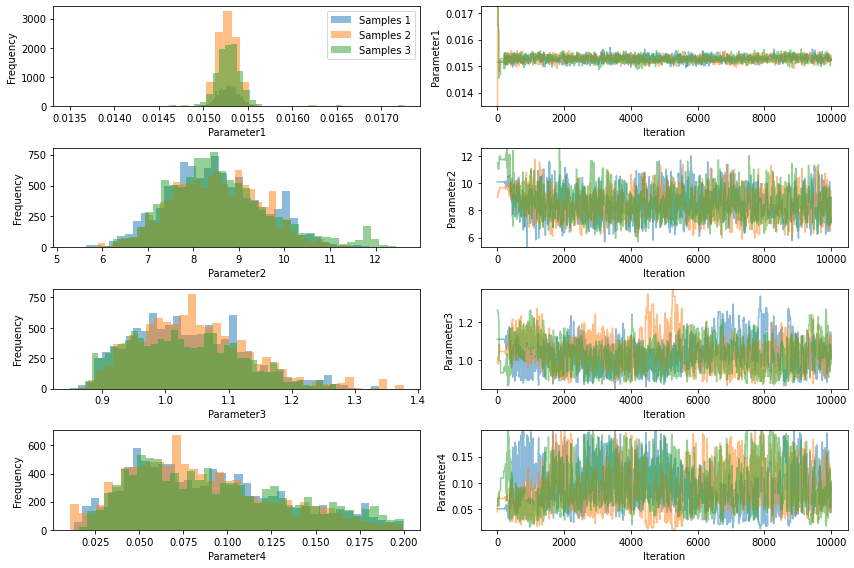

In [41]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HaarioACMC chains:
# [hacmc_chains]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hacmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(chains)
plt.show()

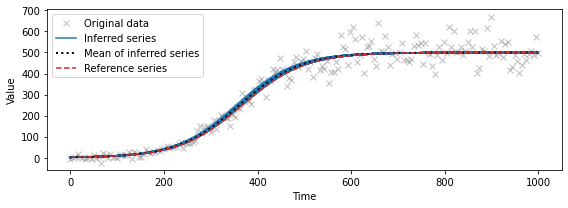

In [42]:
# Show predicted time series for the first chain
pints.plot.series(chains[0, 200:], problem, true_parameters)
plt.show()

### 2. Infer parameters with Hamiltonian MCMC

In [44]:
#
# Infer model parameters with Hamiltonian MCMC.
#
# This cell needs the above defined true model parameters and the log-posterior:
# [true_parameters, log-posterior]
#

# Choose starting points for mcmc chains
xs = [
    true_parameters * 1.01,
    true_parameters * 0.9,
    true_parameters * 1.15,
]

# Create MCMC routine
mcmc = pints.MCMCController(
    log_pdf=log_posterior, 
    chains=len(xs),  # number of chains
    x0=xs,   # starting points
    method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
hmcmc_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0         0.333      0:00.0
2     123    0.25      0.25      0.25       0:00.1
3     183    0.2       0.2       0.4        0:00.1
100   6003   0.431     0.52      0.353      0:02.1
200   12003  0.455     0.495     0.356      0:03.9
300   18003  0.43      0.464     0.358      0:05.7
400   24003  0.420398  0.455     0.363      0:07.5
500   30003  0.416     0.424     0.369      0:09.2
600   36003  0.4       0.44      0.38       0:11.0
700   42003  0.387     0.439     0.38       0:12.8
800   48003  0.39      0.428     0.38       0:14.6
900   54003  0.398     0.424612  0.376      0:16.3
1000  59943  0.395     0.425     0.369      0:18.0
Halting: Maximum number of iterations (1000) reached.
Done!


param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
r           0.01    0.00    0.01    0.01   0.01   0.02   0.02     1.60    17.41  0.96
sigma_base  11.99   2.88    7.05    9.33   12.33  14.81  16.32    2.84    17.66  0.98
eta         1.30    0.09    1.20    1.22   1.28   1.38   1.48     3.85    91.96  5.10
sigma_rel   0.09    0.04    0.03    0.05   0.09   0.14   0.15     6.84    37.60  2.08


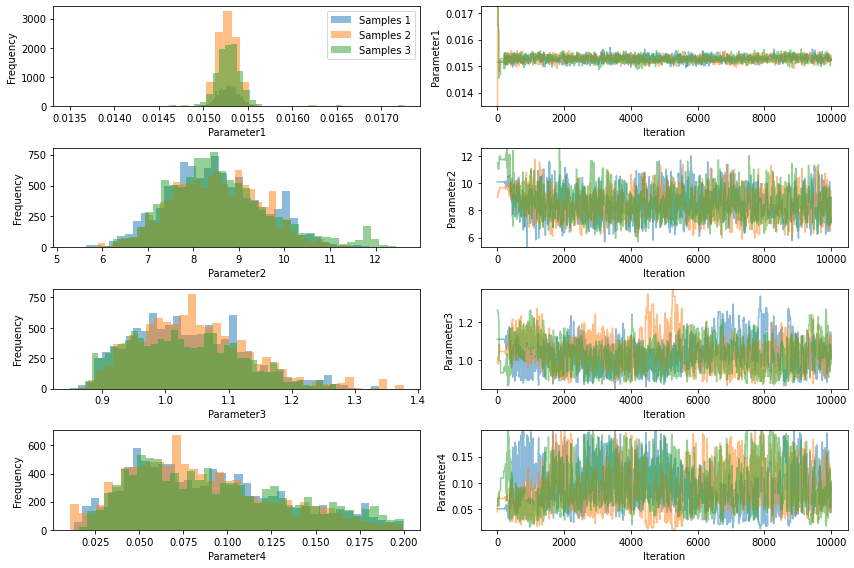

In [45]:
#
# Compute diagnostics and show diagnostic plots.
#
# This cell needs the HamiltonianMCMC chains:
# [hmcmc_chains]
#

import pints
import pints.plot


# Show diagnostics summary
results = pints.MCMCSummary(chains=hmcmc_chains, time=mcmc.time(), parameter_names=['r', 'sigma_base', 'eta', 'sigma_rel'])
print(results)

# Show trace and histogram
pints.plot.trace(chains)
plt.show()

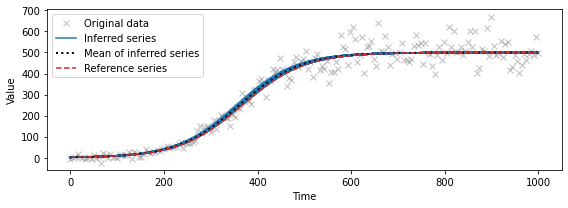

In [46]:
# Show predicted time series for the first chain
pints.plot.series(chains[0, 200:], problem, true_parameters)
plt.show()